In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import csv
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import timm, torch, argparse, yaml, pickle, csv, AutoAugment
from softdataset import TripletImageDataset
from torchvision.transforms import ToTensor, Resize
from torch.utils.data import DataLoader
from collections import OrderedDict as OD
from tqdm import tqdm
from torchvision import transforms
import torchvision.transforms.functional as FF
from torch.nn import functional as F
from torch.nn import *
from torch import nn
from PIL import Image
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from collections import namedtuple as NT

In [2]:
class ContrastiveLoss(nn.Module):

        """

        Contrastive loss

        Takes embeddings of two samples and a target label == 1 if samples are from the same class and label == 0 otherwise

        """

        def __init__(self, margin):
            super(ContrastiveLoss, self).__init__()
            self.margin = margin
            self.eps = 1e-9

        def forward(self, output1, output2, target, size_average=True):
            distances = (output2 - output1).pow(2).sum(1)  # squared distances
            losses = 0.5 * (target * distances + (1 + -1 * target) * F.relu(self.margin - (distances + self.eps).sqrt()).pow(2))
            return losses.mean() if size_average else losses.sum()
    

def get_dl(path, bs, random = True, trainval_json="", trainval="val"):        
    
    ''' 
    Get path to the images and returns dataloader with transformations applied
    Arguments:

    path - path to the dir with images;
    bs - batch_size;
    random - if False loads train test split json file else randomly mix dataset.      

    '''
    
    transformations = {}   

    transformations['qry'] = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        AutoAugment.ImageNetPolicy(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])  
    transformations['pos'] = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])  
    transformations['neg'] = transforms.Compose([
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]) 
    
    dataset = TripletImageDataset(data_dir = path, transform_dic = transformations, random = random, trainval_json=trainval_json, trainval=trainval)  
    all_dl = DataLoader(dataset, batch_size=bs, shuffle=False, drop_last=True, num_workers=8)
    
    num_classes = dataset.get_prod_length()
    print(f"The dataset has {num_classes} classes")
    
    print(f"Number of test samples: {len(dataset)}")
    
    test_dl = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=True, num_workers=8)

    return num_classes, dataset, test_dl


def load_checkpoint(checkpoint_path, model_name, pretrained=False, num_classes=None, from_pytorch_lightning=True, init_conv=False):

        ''' 
        
        Loads checkpoint_path from the given path to the directory with the trained model.
        Arguments:
        
        checkpoint_path - path to the dir with the trained model;
        model_name - name of the trained model (name is the same as in the timm library);
        pretrained - creates a model with pretrained weights on ImageNet;
        init_conv - initial convolution layer, default is True;
        from_pytorch_lightning - used to load the trained model from pytorch_lightning.
        If True the model is trained using pytorch_lightning, else with a regular torch library;
        Default is False
        
        '''        
        assert num_classes is not None, "Please set the number of classes in the dataset!"
        
        if from_pytorch_lightning: # for a pytorch_lightning model
            checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
            # print(checkpoint['state_dict'].keys())
            if init_conv:                
                base_model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
                conv_layer = torch.nn.Sequential(torch.nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1),padding=(1,1), bias=False), 
                 # nn.Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2),padding=(1,1), bias=False), 
                 # nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1)),
                 torch.nn.SiLU(inplace=True))
                model = torch.nn.Sequential(conv_layer, base_model) 
                print("Model with init_conv True")
            else:
                model = timm.create_model(model_name, num_classes=num_classes)
                print("Model with init_conv False")

            # create new OrderedDict that does not contain `model.` (for the checkpoint from the pytorch_lightning)
            new_state_dict = OrderedDict()
            for k, v in checkpoint['state_dict'].items():
                name = k.replace("model.", "") # remove `model.`
                new_state_dict[name] = v
            # load params
            model.load_state_dict(new_state_dict, strict=True)
            print(f"Model {model_name} trained using pytorch lightning checkpoint is successfully loaded!")

        else: # for a regular torch model  
            if pretrained:
                model = timm.create_model(model_name, num_classes=num_classes)
                print(f"Model {model_name} with pretrained weights is successfully loaded!")
            else:
                model = timm.create_model("rexnet_150")
                state_dict = torch.load(checkpoint_path)
                model.load_state_dict(state_dict['state_dict'])
                num_features = model.head.fc.in_features
                model.classifier = Linear(num_features, num_classes) if num_classes > 0 else Identity() 
                print(f"Model {model_name} with the best weights is successfully loaded!")            

        return model
    
def inference(model, dataloader, device):

        ''' 
        
        Inference using trained model and test dataloader.
        Arguments:
        
        model - trained model from the checkpoint (see load_checkpoint function);
        dataloader - test dataloader (see get_dl function);
        device - gpu device.
        
        '''   
        
        loss_module = torch.nn.CosineEmbeddingLoss(margin=0.5).to('cuda')
        pool = nn.AvgPool2d((7,7))
        ims, poss, pos_scores, neg_scores, fms_ims_all, fms_poss_all, fms_negs_all, losses, classes_all, pred_lbls_all = [], [], [], [], [], [], [], [], [], []
        cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
        model.to(device)
        model.eval()
        
        def forward(inp):
            def dict_to_namedtuple(dic):
                return NT('GenericDict', dic.keys())(**dic)

            dic = {}                        
            fm = model.forward_features(inp)
            pool = nn.AvgPool2d((7,7))
            lbl = model.forward_head(fm)
            dic["feature_map"] = torch.reshape(pool(fm), (-1, fm.shape[1]))
            dic["class_pred"] = lbl
            out = dict_to_namedtuple(dic)
            return out
        
        model.forward = forward
        print("Obtaining embeddings...")
        
        for i, batch_all in tqdm(enumerate(dataloader)):
            ims_all, poss_all, negs_all, clss_all, regs_all = batch_all['qry'], batch_all['pos'][0], batch_all['neg'][0], batch_all['cat_idx'], batch_all['prod_idx']
            ims.extend(ims_all)
            poss.extend(poss_all)
            classes_all.extend(regs_all.to(device)) 
            
            with torch.no_grad():
                # with torch.cuda.amp.autocast():
                out_ims_all = model(ims_all.to(device))            
                fm_ims_all, lbl_ims_all = out_ims_all[0], out_ims_all[1] # get feature maps [0] and predicted labels [1]
                vals, inds = torch.topk(lbl_ims_all, k=3)
                out_poss_all = model(poss_all.to(device))
                fm_poss_all, lbl_poss_all = out_poss_all[0], out_poss_all[1] # get feature maps [0] and predicted labels [1]
                out_negs_all = model(negs_all.to(device))
                fm_negs_all, lbl_negs_all = out_negs_all[0], out_negs_all[1] # get feature maps [0] and predicted labels [1]
                fms_ims_all.extend(fm_ims_all) #bs, fm 
                fms_poss_all.extend(fm_poss_all)
                fms_negs_all.extend(fm_negs_all)
                pred_lbls_all.extend(inds)
        print("Embeddings are obtained!")        
        print("Calculating metrics...")
        top1 = 0 
        top3 = 0
        fms_ims_all = torch.stack(fms_ims_all) 
        fms_poss_all = torch.stack(fms_poss_all)
        fms_negs_all = torch.stack(fms_negs_all)        
        ims = torch.stack(ims)
        poss = torch.stack(poss)        
        pred_lbls_all = torch.stack(pred_lbls_all)   
        classes_all = torch.stack(classes_all)         
            
        for idx, fm in enumerate(fms_ims_all):
            score = cos(fm.unsqueeze(0), fms_poss_all) #(len(dl))
            pos_score = cos(fm.unsqueeze(0), fms_poss_all[idx].unsqueeze(0)) #(len(dl))
            pos_scores.append(pos_score.item())
            
            score_val, score_inds = torch.topk(score, k=3)  
            if classes_all[idx] in classes_all[score_inds]:
                top3+=1
            if classes_all[idx] in classes_all[score_inds[0]]:
                top1+=1    
            
        return OD([('loss', np.mean(losses)), ('top1', top1/len(fms_ims_all)), ('top3', top3/len(fms_ims_all)), 
                   ('scores', torch.mean(torch.FloatTensor(pos_scores))), ('fms_ims_all', fms_ims_all), ('classes_all', classes_all), 
                   ('fms_poss_all', fms_poss_all), ('ims', ims), ('poss', poss), ('fms_negs_all', fms_negs_all)])

In [3]:
ims_path = "/home/ubuntu/workspace/dataset/test_dataset_svg/test_dataset_svg_1122_3_org"
bs=128
device='cuda:1'
num_classes, test_ds, test_dl = get_dl(path=ims_path, bs=bs)
checkpoint_path = "/home/ubuntu/workspace/bekhzod/pytorch_lightning/saved_models/rexnet_150_Adam_0.0003/Image Retrieval/2tohj0pv/checkpoints/epoch=21-val_loss=0.64-cos_sims=0.96-val_top1=0.97.ckpt" #change checkpoint
m = load_checkpoint(checkpoint_path, num_classes=num_classes, model_name='rexnet_150')
results = inference(m, test_dl, device)
results['top3'], results['top1'], results['scores']

The dataset has 178 classes
Number of test samples: 2853
Model with init_conv False
Model rexnet_150 trained using pytorch lightning checkpoint is successfully loaded!
Obtaining embeddings...


22it [00:07,  3.01it/s]


Embeddings are obtained!
Calculating metrics...


/home/ubuntu/anaconda3/envs/retrieval/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu/anaconda3/envs/retrieval/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(0.8615056818181818, 0.8600852272727273, tensor(0.7534))


Input Image


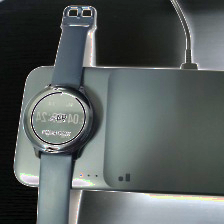


Positive Image



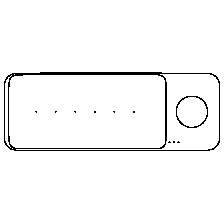


Predicted Images



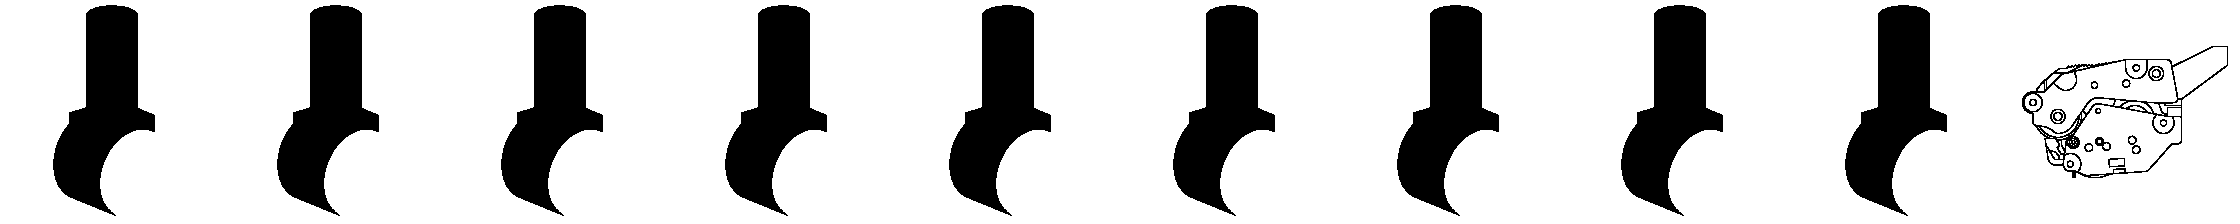

top3: False, top1: False, sim_score: 0.6512970924377441

Input Image


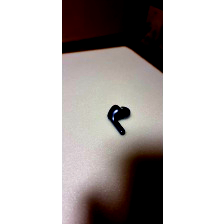


Positive Image



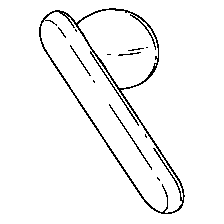


Predicted Images



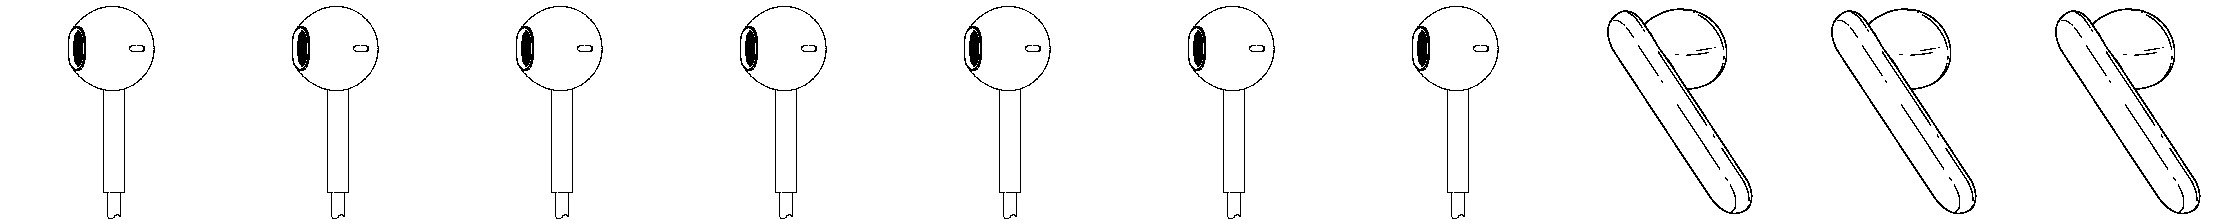

top3: True, top1: False, sim_score: 0.635922908782959

Input Image


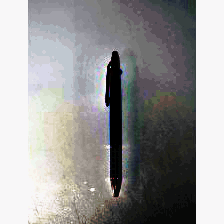


Positive Image



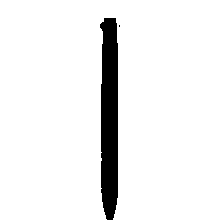


Predicted Images



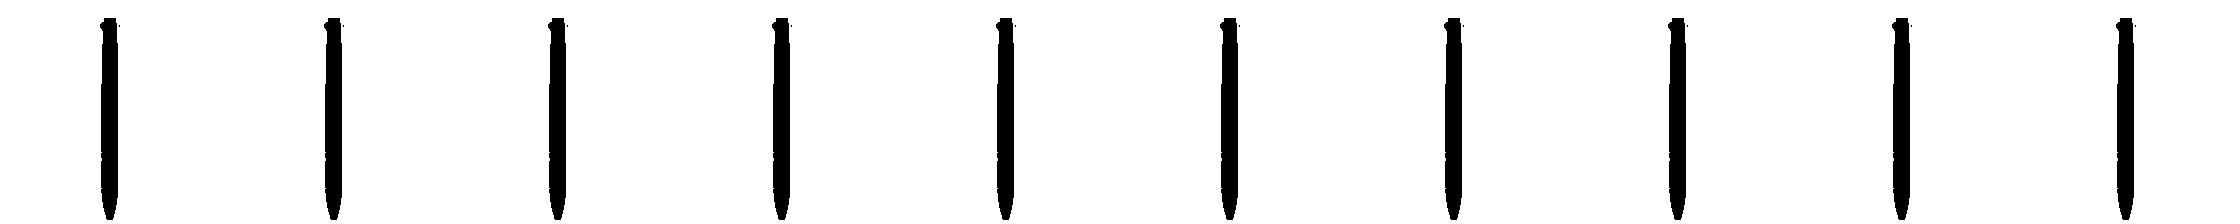

top3: True, top1: True, sim_score: 0.7942564487457275

Input Image


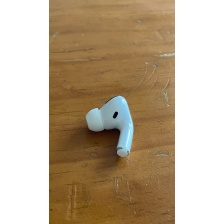


Positive Image



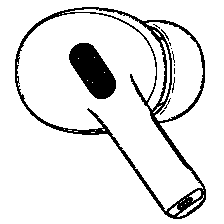


Predicted Images



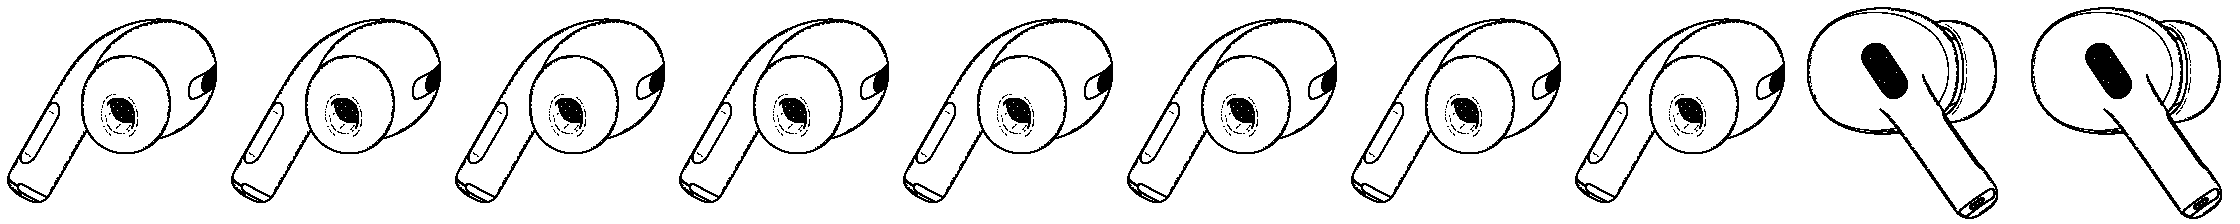

top3: True, top1: True, sim_score: 0.7812008857727051

Input Image


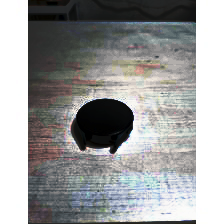


Positive Image



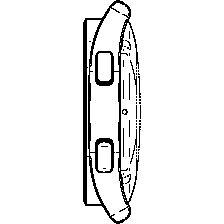


Predicted Images



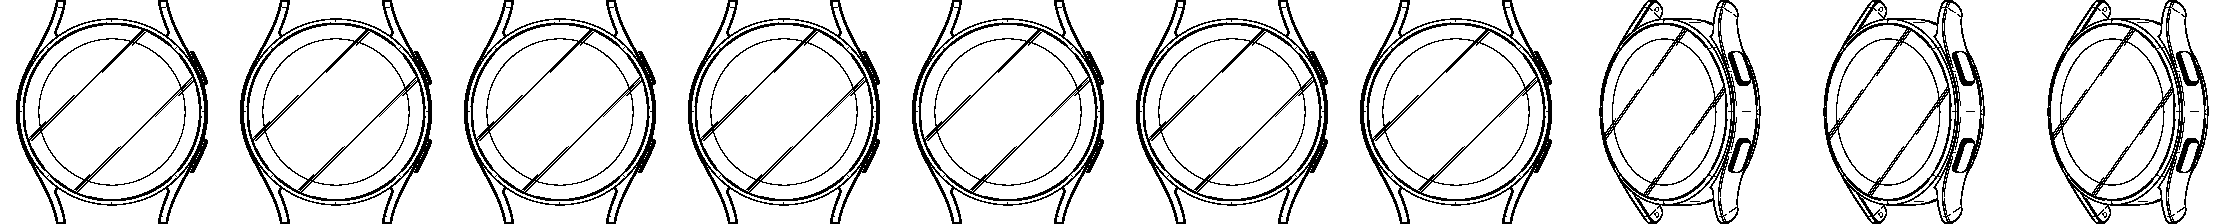

top3: True, top1: True, sim_score: 0.7810646295547485

Input Image


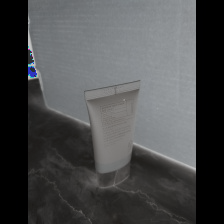


Positive Image



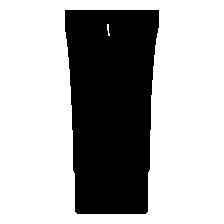


Predicted Images



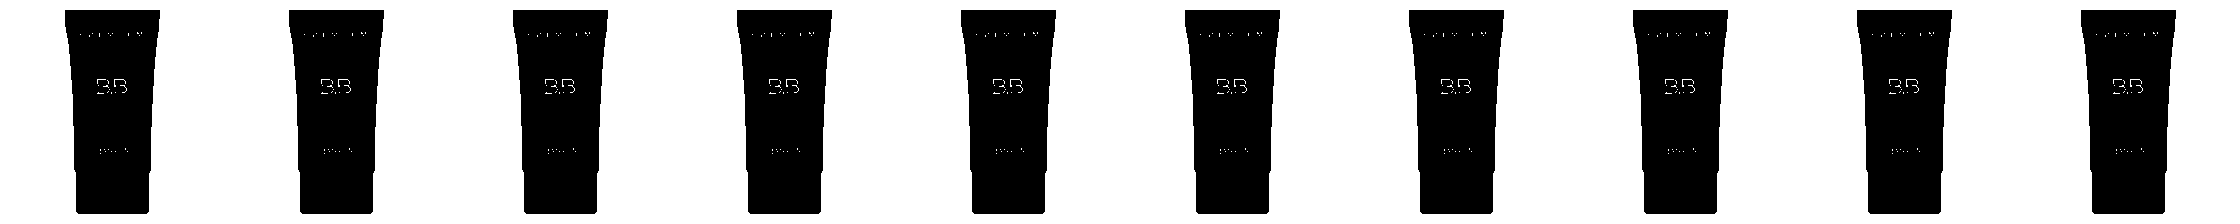

top3: True, top1: True, sim_score: 0.8709194660186768

Input Image


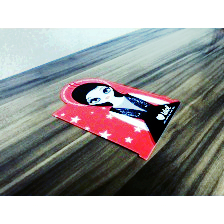


Positive Image



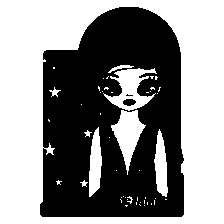


Predicted Images



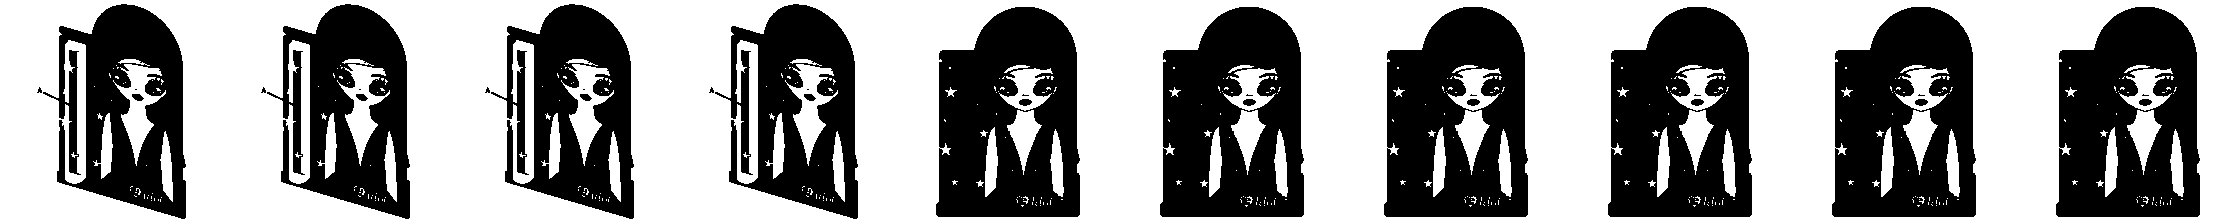

top3: True, top1: True, sim_score: 0.6855138540267944

Input Image


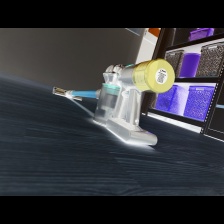


Positive Image



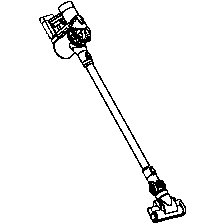


Predicted Images



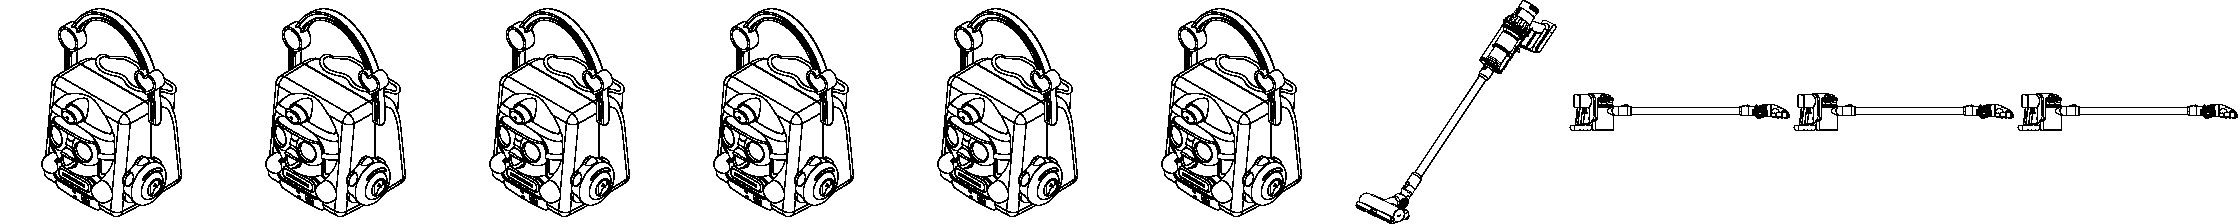

top3: True, top1: False, sim_score: 0.6159096956253052

Input Image


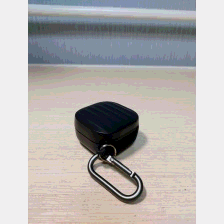


Positive Image



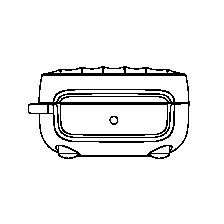


Predicted Images



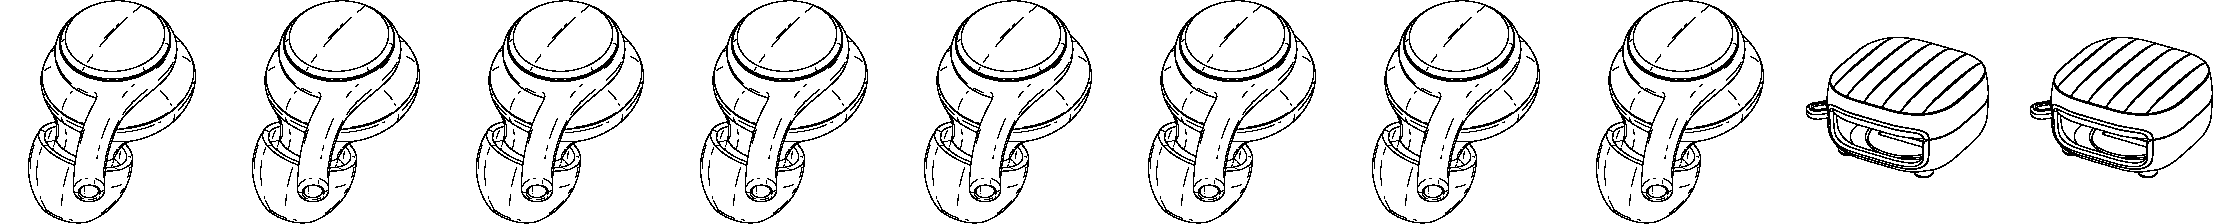

top3: True, top1: False, sim_score: 0.702998697757721

Input Image


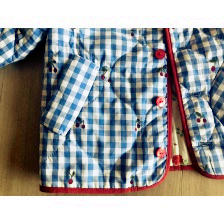


Positive Image



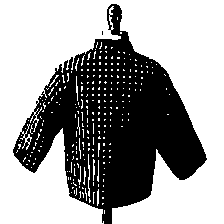


Predicted Images



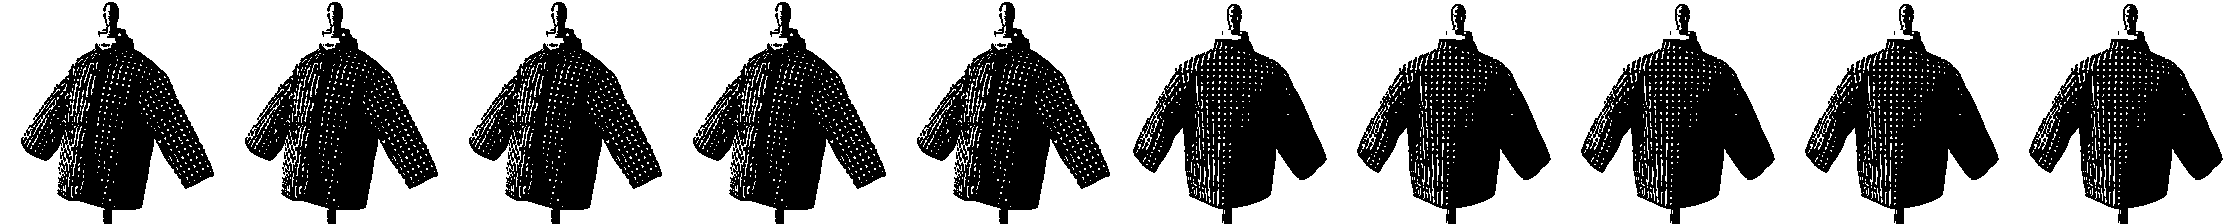

top3: True, top1: True, sim_score: 0.8557083010673523

Input Image


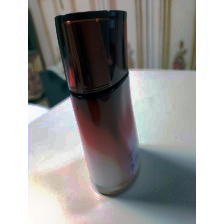


Positive Image



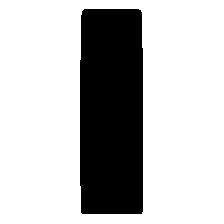


Predicted Images



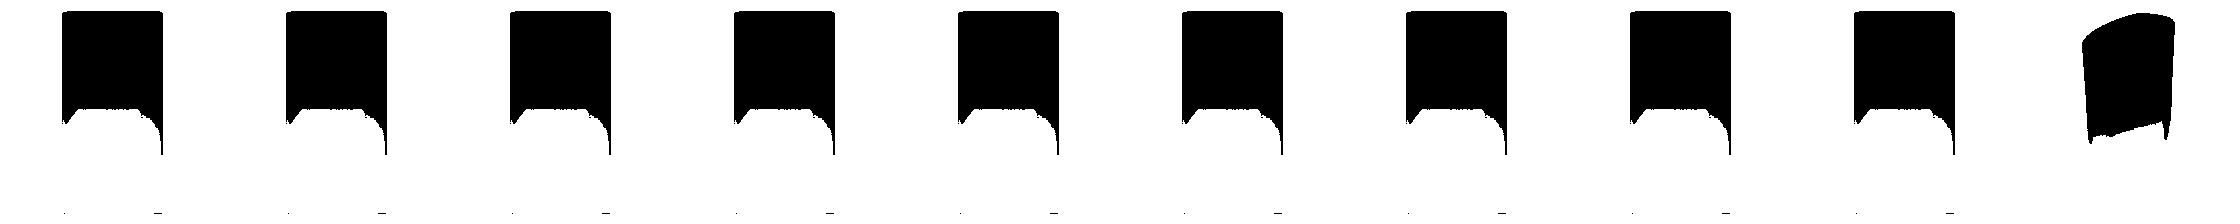

top3: True, top1: True, sim_score: 0.7500883936882019

Input Image


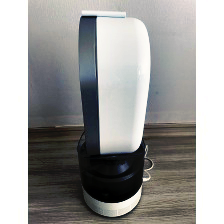


Positive Image



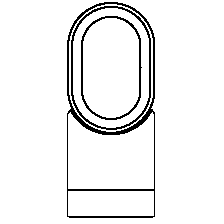


Predicted Images



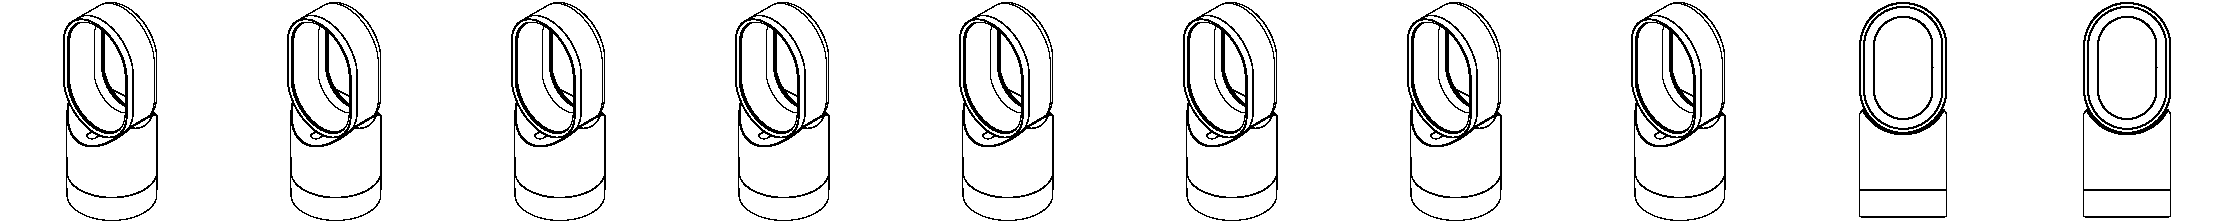

top3: True, top1: True, sim_score: 0.8057771921157837

Input Image


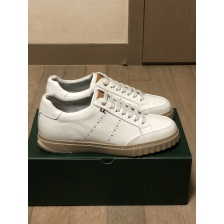


Positive Image



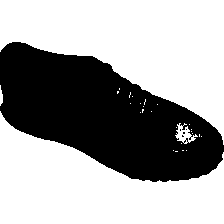


Predicted Images



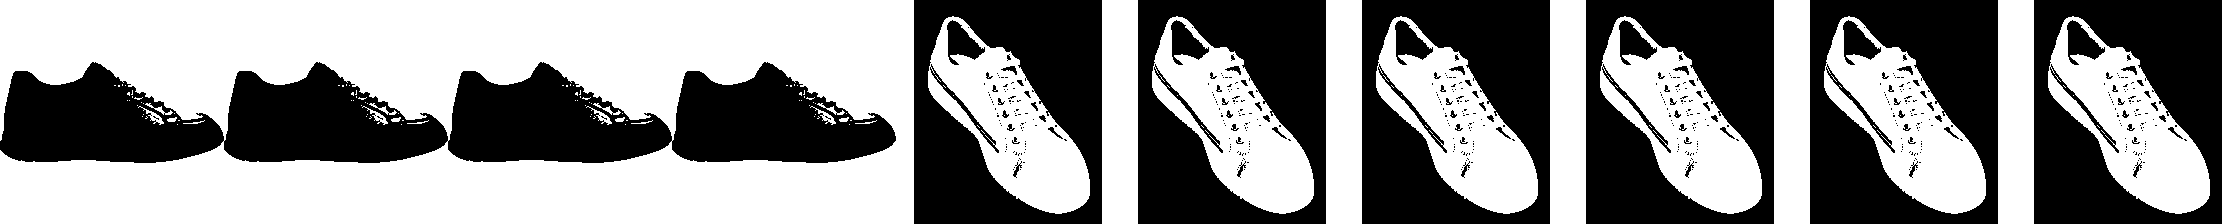

top3: True, top1: True, sim_score: 0.8820081949234009

Input Image


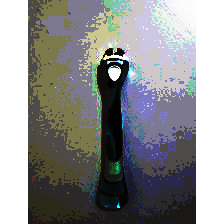


Positive Image



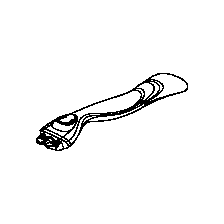


Predicted Images



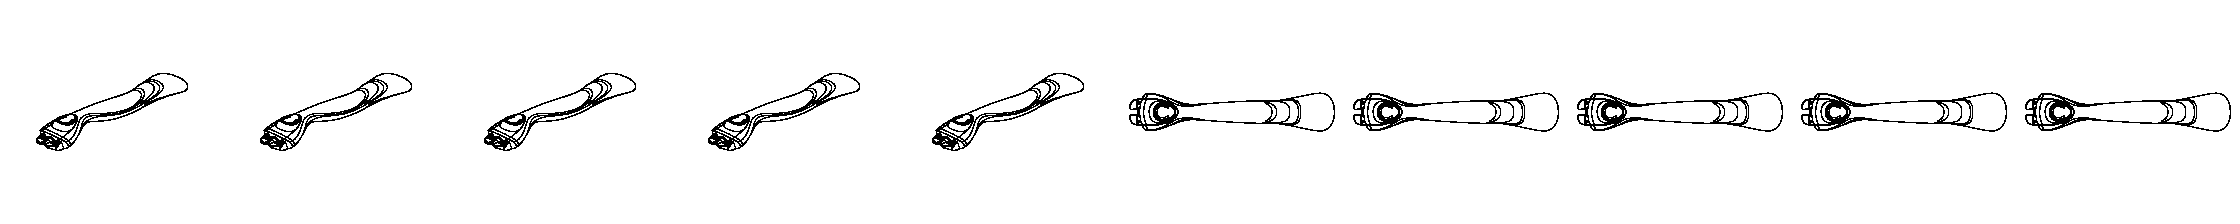

top3: True, top1: True, sim_score: 0.8233716487884521

Input Image


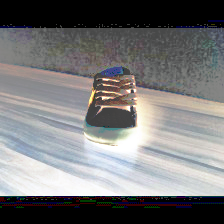


Positive Image



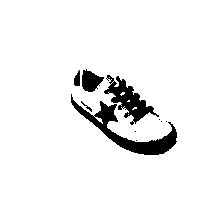


Predicted Images



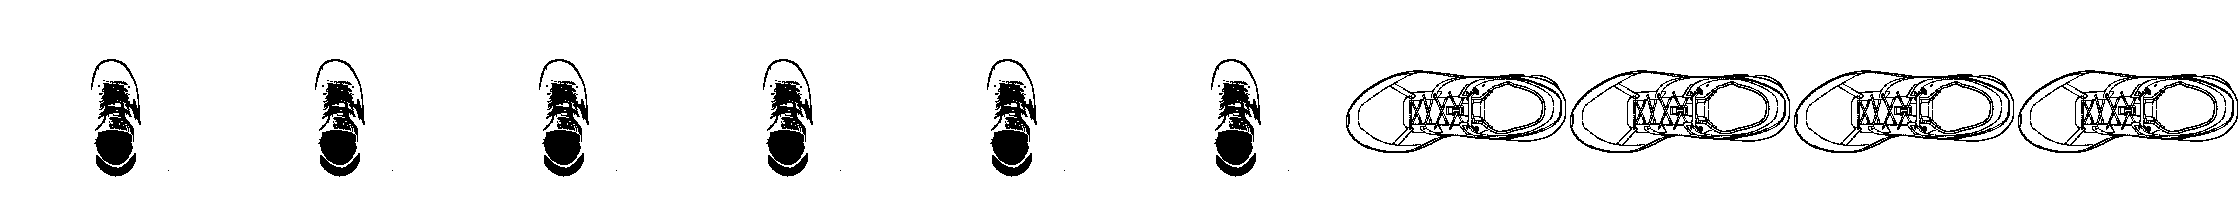

top3: True, top1: True, sim_score: 0.7279621362686157

Input Image


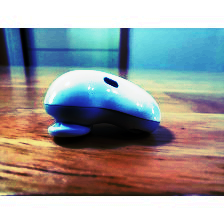


Positive Image



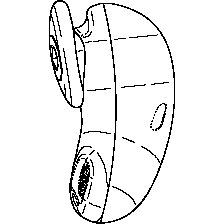


Predicted Images



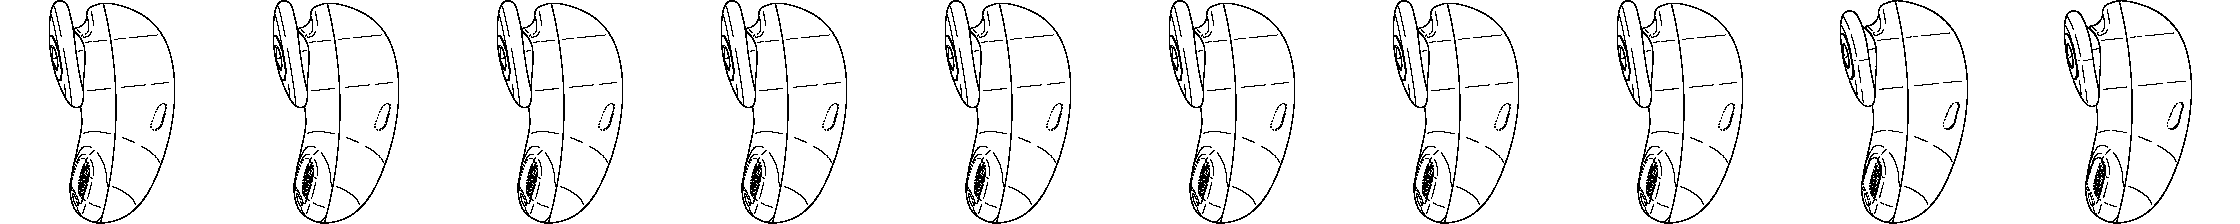

top3: True, top1: True, sim_score: 0.7762206792831421

Input Image


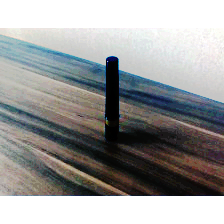


Positive Image



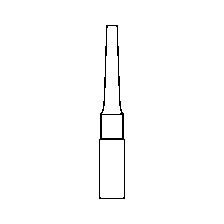


Predicted Images



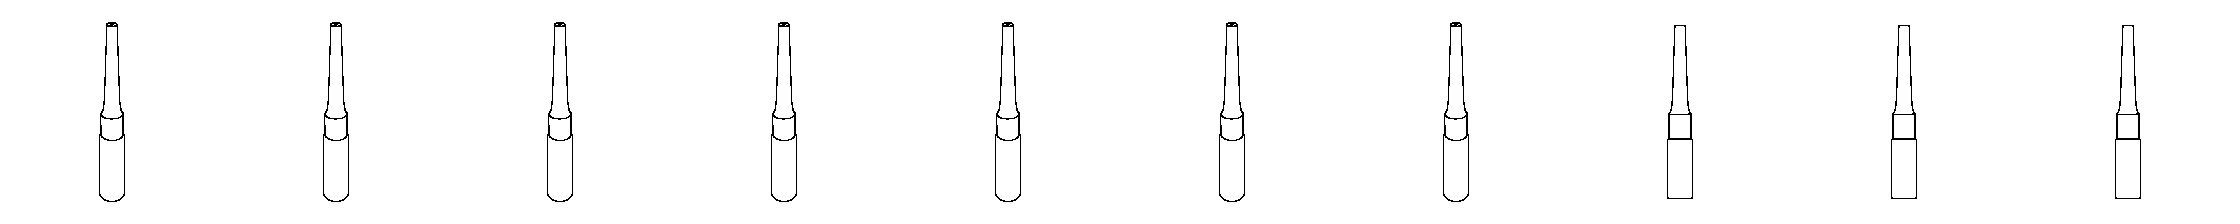

top3: True, top1: True, sim_score: 0.7933967113494873

Input Image


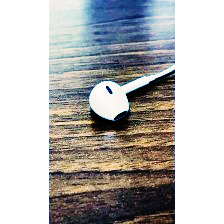


Positive Image



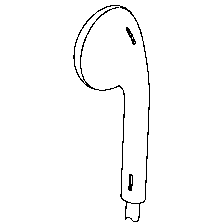


Predicted Images



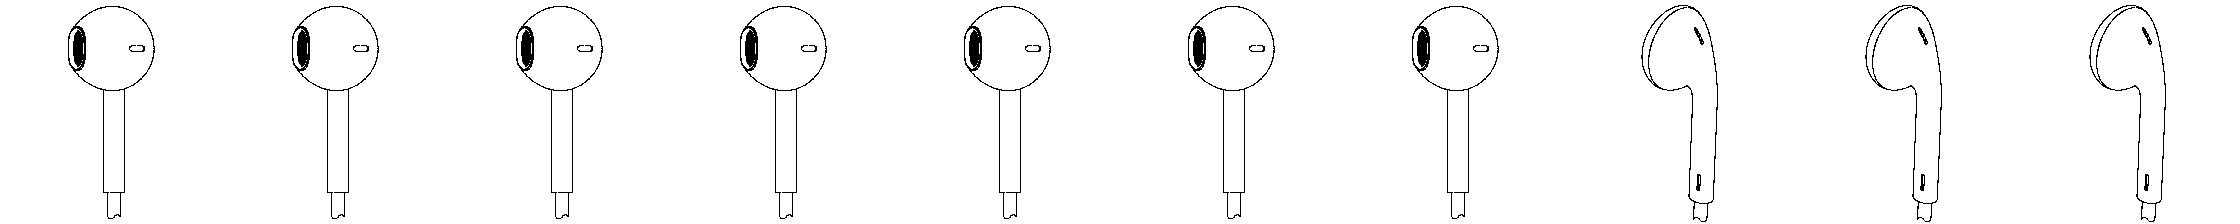

top3: True, top1: True, sim_score: 0.8495028018951416

Input Image


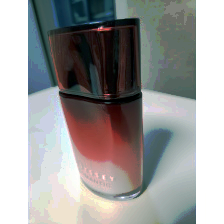


Positive Image



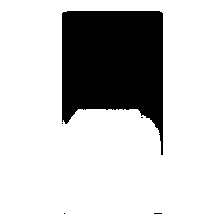


Predicted Images



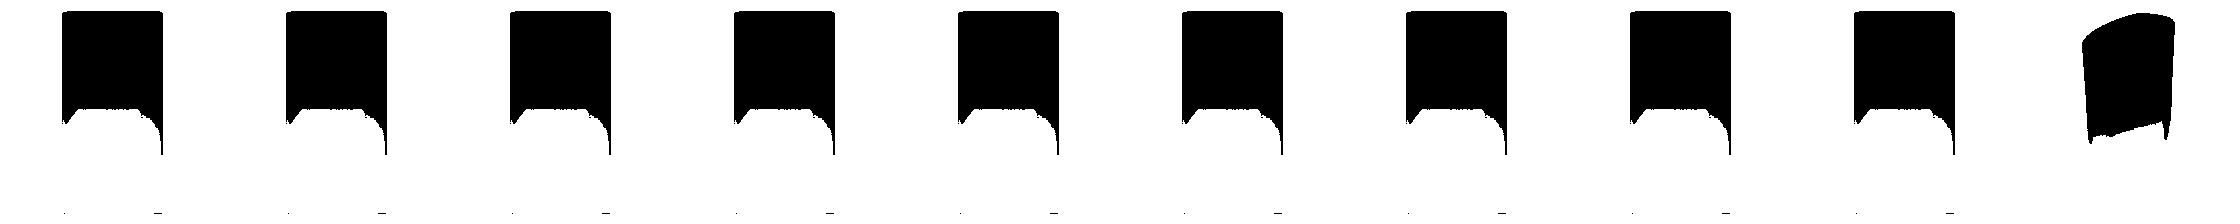

top3: True, top1: True, sim_score: 0.7419844269752502

Input Image


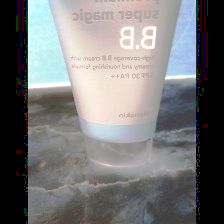


Positive Image



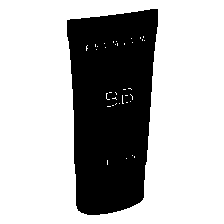


Predicted Images



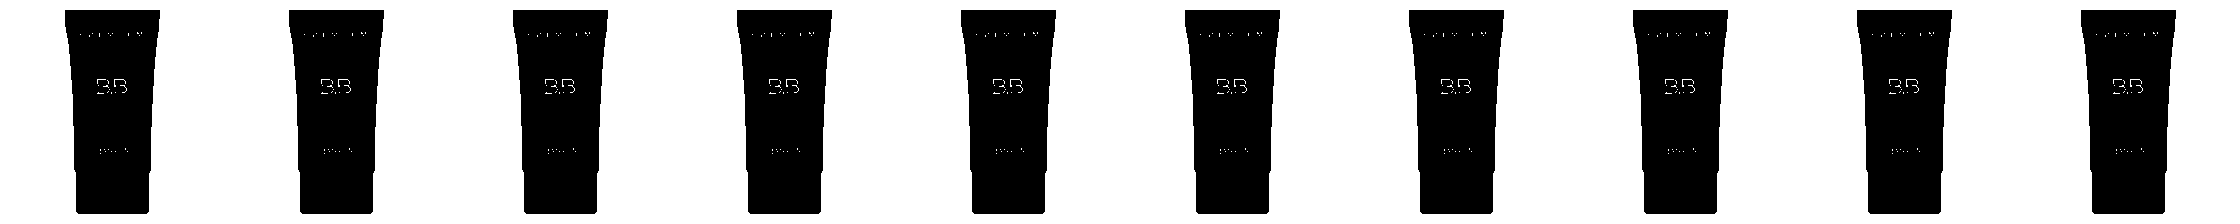

top3: True, top1: True, sim_score: 0.7851435542106628


In [4]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                 std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                            transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                 std = [ 1., 1., 1. ]),
                           ])
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
# scores = results['s']
fms_ims_all = results['fms_ims_all']
fms_poss_all = results['fms_poss_all']
fms_negs_all = results['fms_negs_all']
ims = results['ims']
poss = results['poss']
classes_all = results['classes_all']
# negs = results['negs']

cnt = 0
    
for i, im in enumerate(ims):
    top3, top1 = 0, 0
    if i == 20:
        break
    print('\nInput Image')
    display(Image.fromarray((invTrans(ims[i])*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    print('\nPositive Image\n')
    display(Image.fromarray((invTrans(poss[i])*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)))
    cnt += 1
    values, indices = torch.topk(cos(fms_ims_all[i], fms_poss_all), k=10)
#     print(f"Predicted indices: {indices}")
#     print(f"Coorect index3: {classes_all[indices]}")
#     print(f"Coorect index1: {classes_all[indices[0]]}")
    if classes_all[i] in classes_all[indices]:
        top3+=1
    if classes_all[i] in classes_all[indices[0]]:
        top1+=1
        
#     top3 = len(indices[i == indices])
#     top1 = len(indices[i == indices[0]])

    img_list = []
    img_list_gt = []
    for j in indices:
        img = (invTrans(poss[j])*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_gt = (invTrans(poss[i])*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
        img_list.append(img)
        img_list_gt.append(img_gt)
    print('\nPredicted Images\n')
    display(Image.fromarray(np.concatenate(img_list, axis=1)))
#     print('\nGT sketch \n')
#     display(Image.fromarray(np.concatenate(img_list_gt, axis=1)))

    print(f"top3: {top3 == 1}, top1: {top1 == 1}, sim_score: {values[0].item()}")